# Introduction to CUDA-Q Dynamics (Time Dependent Hamiltonians)

## The Landau-Zener model

In this lab we will learn how to implement time dependent Hamiltonian terms and custom operators.
This is important functionality for modeling the application of control pulses to qubits or other interactions that maybe changing in time. 

In the first section we will use the example of a Landau-Zener transition to demonstrate two ways of implementing time dependent terms.

The [Landau-Zener model](https://en.wikipedia.org/wiki/Landau%E2%80%93Zener_formula) describes the transition probability of a quantum system with two energy levels that cross each other as a function of an external parameter. For example, one can consider two spins weakly coupled to each other ($g$) while an external magnetic field is swept. If the two spins have an energy spectrum that cross each other as a function of the magnetic field, an avoided crossing is created due to the interaction of the spins with each other.

If the magnetic field is swept slowly (adiabatically), no transitions across the splitting occurs. However, if it is swept quickly (diabatically), the transition hops over the splitting, effectively ignoring the splitting. If swept at an intermediate rate, the transition probability is given by a well defined probability. 

![alt text](images/LZ_transition.png)

Figure 1. Sketch of two crossing energy levels with an avoided crossing along a parameter z. Image credit: Wikipedia

## Section 1 - Implementing time dependent terms

In this lab we will learn to implement time dependent Hamiltonian terms with:
- a time dependent scalar coefficient via `ScalarOperator`
- a `tensor callback` function for custom operators

We consider the following simple Hamiltonian representing the lowest two levels of the system. Note we consider first a small system as an instructional example to demonstrate the above features. A system this small won't experience a good acceleration run on GPU, but the features here can easily be scaled towards much larger systems which will experience a significant GPU speed-up.

$$ 
\hat H = \begin{bmatrix}
-\alpha t & g \\
g & \alpha t
\end{bmatrix}
$$

Here the coupling between levels is denoted by $g$ and the time dependent parameter is denoted by $\alpha$. The above Hamiltonian can be of course decomposed into the following Pauli operators:

$\hat H = g\hat\sigma_x - \alpha t \hat\sigma_z$

We can implement the Pauli decomposition easily by constructing our Hamiltonian in CUDA-Q Dynamics with our typical spin operators and by leveraging a `ScalarOperator` with a time dependence and multiplying that by the $\sigma_z$ term. The transition probability is known to be $P = e^{-\pi g^2/\alpha}$ but we will observe this by performing the following simulation.

In [1]:
import cudaq
from cudaq import spin, operators, ScalarOperator, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

In [4]:
# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Define some shorthand operators
sx = spin.x(0)
sz = spin.z(0)
sm = operators.annihilate(0)
sm_dag = operators.create(0)

# Dimensions of sub-system. We only have a single degree of freedom of dimension 2 (two-level system).
dimensions = {0: 2}

Let's set a target transition probability of 0.75 to inform our value of $\alpha$. We will see that computing the simulation will yield a transition result predicted by the theory.

In [5]:
# Define the Hamiltonian with spin operators and a ScalarOperator
# Set the coupling to 2pi
g = 2 * np.pi
# The target ground state probability that we want to achieve
target_p0 = 0.75
# Compute `alpha` parameter:
alpha = (-np.pi * g**2) / np.log(target_p0)

We define our Hamiltonian below and use the `ScalarOperator` to multiply the $\sigma_z$ term by $t$ in a lambda function. This functionality also enables the easy implementation of time dependent drive terms and envelop functions by simply replacing the function in the `ScalarOperator` argument.

In [6]:
# Hamiltonian
hamiltonian = g * sx - alpha * ScalarOperator(lambda t: t) * sz

In [7]:
# Initial state of the system (ground state)
psi0 = cudaq.State.from_data(cp.array([1.0, 0.0], dtype=cp.complex128))

# Schedule of time steps (simulating a long time range)
steps = np.linspace(-2.0, 2.0, 5000)
schedule = Schedule(steps, ["t"])

# Run the simulation.
evolution_result = cudaq.evolve(hamiltonian,
                                dimensions,
                                schedule,
                                psi0,
                                observables=[operators.number(0)],
                                collapse_operators=[],
                                store_intermediate_results=True,
                                integrator=ScipyZvodeIntegrator())

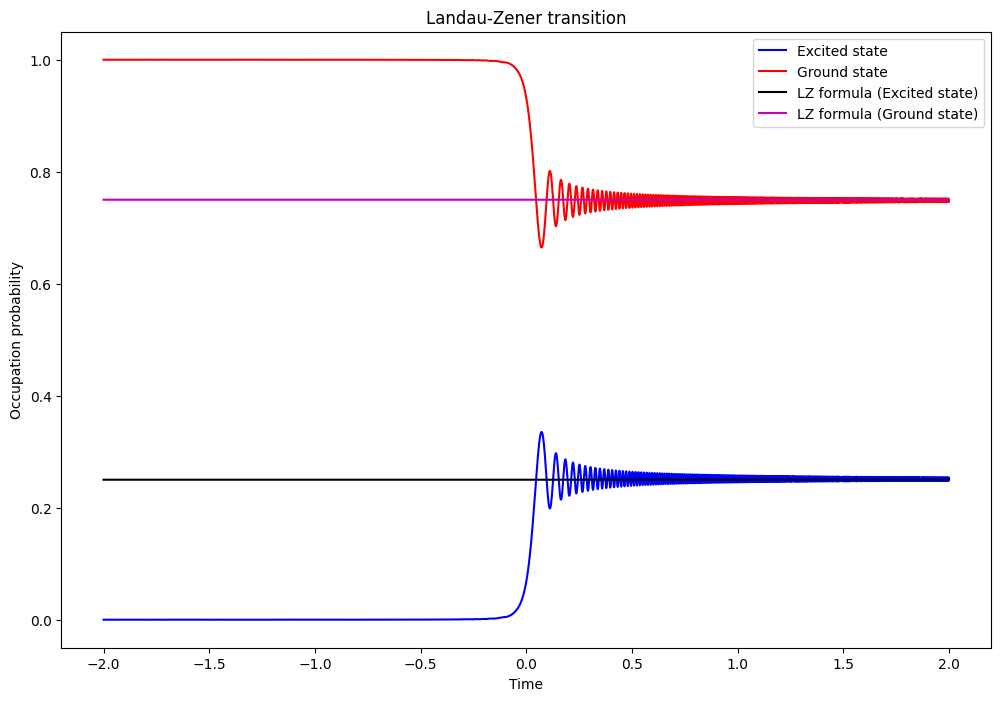

In [8]:
# Collect the results and plot
prob1 = [
    exp_vals[0].expectation()
    for exp_vals in evolution_result.expectation_values()
]

prob0 = [1 - val for val in prob1]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(steps, prob1, 'b', steps, prob0, 'r')
ax.plot(steps, (1.0 - target_p0) * np.ones(np.shape(steps)), 'k')
ax.plot(steps, target_p0 * np.ones(np.shape(steps)), 'm')
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
ax.set_title("Landau-Zener transition")
ax.legend(("Excited state", "Ground state", "LZ formula (Excited state)",
           "LZ formula (Ground state)"),
          loc=0)

We see the transition probability of the ground state converges to the predicted probability of 0.75.

## Section 2 - Implementing custom operators

In the previous section we decomposed the Hamiltonian into spin operators to apply the time dependence to the $\sigma_z$ terms. Alternatively, we can directly represent the Hamiltonian
$$ 
\hat H = \begin{bmatrix}
-\alpha t & g \\
g & \alpha t
\end{bmatrix}
$$
with a `tensor callback` and by defining an `ElementaryOperator`.

Let's define the above Hamiltonian in a matrix in the function `callback_tensor(t)` which accepts time as an argument.

In [11]:
from cudaq import ElementaryOperator

def callback_tensor(t):
    return np.array([[-alpha * t, g], [g, alpha * t]], dtype=np.complex128)

We can now define an operator with this callback tensor, labeled `lz_op`.

In [12]:
# Let's define the control term as a callback tensor that acts on 2-level systems
ElementaryOperator.define("lz_op", [2], callback_tensor)

We can define our hamiltonian now with this single `lz_op` `ElementaryOperator`, applied to the 0th degree of freedom. 

In [13]:
# Hamiltonian
hamiltonian = ElementaryOperator("lz_op", [0])

We can run the rest of the simulation as before.

In [15]:
# Dimensions of sub-system. We only have a single degree of freedom of dimension 2 (two-level system).
dimensions = {0: 2}

# Initial state of the system (ground state)
psi0 = cudaq.State.from_data(cp.array([1.0, 0.0], dtype=cp.complex128))

# Schedule of time steps (simulating a long time range)
steps = np.linspace(-2.0, 2.0, 5000)
schedule = Schedule(steps, ["t"])

In [16]:
# Run the simulation.
evolution_result = cudaq.evolve(hamiltonian,
                                dimensions,
                                schedule,
                                psi0,
                                observables=[operators.number(0)],
                                collapse_operators=[],
                                store_intermediate_results=True,
                                integrator=ScipyZvodeIntegrator())

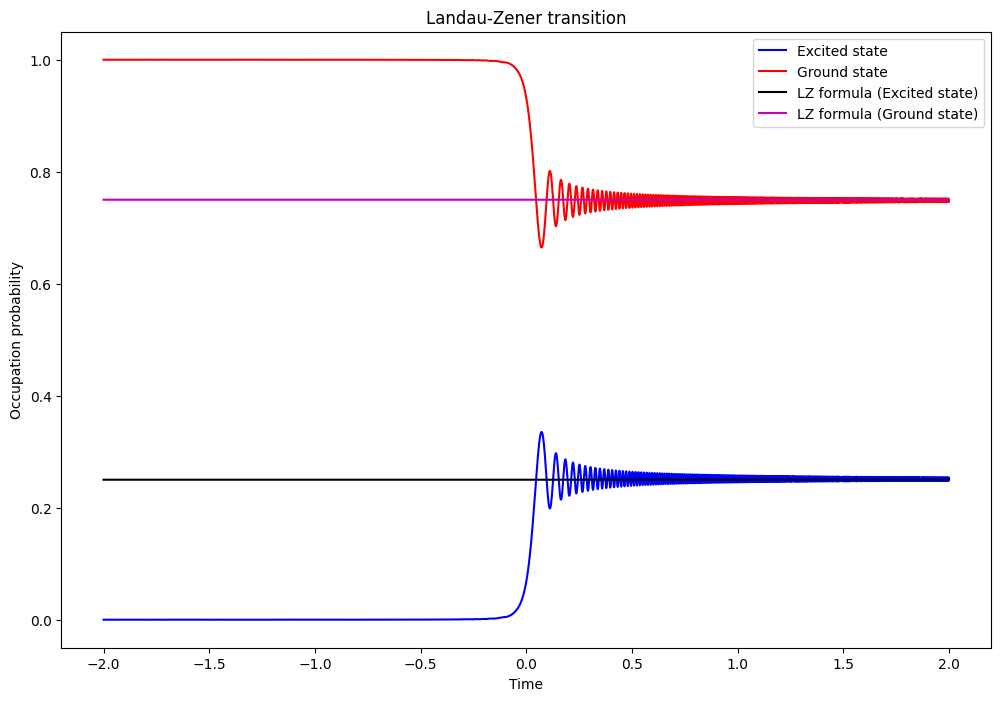

In [18]:
prob1 = [
    exp_vals[0].expectation()
    for exp_vals in evolution_result.expectation_values()
]

prob0 = [1 - val for val in prob1]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(steps, prob1, 'b', steps, prob0, 'r')
ax.plot(steps, (1.0 - target_p0) * np.ones(np.shape(steps)), 'k')
ax.plot(steps, target_p0 * np.ones(np.shape(steps)), 'm')
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
ax.set_title("Landau-Zener transition")
ax.legend(("Excited state", "Ground state", "LZ formula (Excited state)",
           "LZ formula (Ground state)"),
          loc=0)

## Section 3 - Heisenberg Model with a time-varying magnetic field

In this section  we will now look at a much larger quantum system, considering a 1-D chain of 10 spins according to the Heisenberg Hamiltonian, adding a time-dependent transverse magnetic field after a delay. We can use this system to model quantum quench dynamics.

$\hat H = J_{ij}\sum S_i \cdot S_j + B_x (t) \sum \sigma^x_i $

 For this example, we consider the case where the $\sigma^z_i \sigma^z_{i+1}$ coupling is dominant, and prepare the system in an alternating spin up and down state, the approximate ground state.

  ![alt text](images/Spin_chain.png)

image credit: Wikipedia



In [ ]:
# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# In this example, we solve the Quantum Heisenberg model (https://en.wikipedia.org/wiki/Quantum_Heisenberg_model),
# which exhibits the so-called quantum quench effect.

# Number of spins
N = 10

dimensions = {}
for i in range(N):
    dimensions[i] = 2

# Initial state: alternating spin up and down
spin_state = ''
for i in range(N):
    spin_state += str(int(i % 2))



## Exercise 1 - Define a time-varying magnetic field

Let us construct the Hamiltonian with a step function B-field that turns on with magnitude 2.0 after a time delay=2.5. Modify the `B_field` function below to reflect this.

In [ ]:
# Define a time dependent B field
delay=2.5
def B_field(time):
    if time<delay:
        B=0
    else:
        B=2.0
        # B=2.0*np.sin(2*np.pi*time)
    return B

Now add the magnetic field term to the Hamiltonian. Assume the B-field lies in the x direction. The spin-spin Hamiltonian terms are given already.

In [ ]:

# Heisenberg model spin coupling strength
Jx = -0.2
Jy = -0.2
Jz = -1.0

# Construct the Hamiltonian
H = operators.zero()

# Spin-spin terms
for i in range(N - 1):
    H += Jx * spin.x(i) * spin.x(i + 1)
    H += Jy * spin.y(i) * spin.y(i + 1)
    H += Jz * spin.z(i) * spin.z(i + 1)

# Magnetic Field terms
for i in range(N):
    H += ScalarOperator(B_field) * spin.x(i) 

We can now execute the simulation, measuring the $\sigma^z_i$ expectation. Other common observables for this system are spin correlators $\langle \sigma^z_i \sigma^z_j \rangle$ and the magnetization $M = \frac{1}{N} \sum \langle\sigma^z_i\rangle$

In [39]:
# Define the time schedule
steps = np.linspace(0.0, 5, 1000)
schedule = Schedule(steps, ["time"])

# Prepare the initial state vector
psi0_ = cp.zeros(2**N, dtype=cp.complex128)
psi0_[int(spin_state, 2)] = 1.0
psi0 = cudaq.State.from_data(psi0_)

# Run the simulation
evolution_result = cudaq.evolve(H,
                                dimensions,
                                schedule,
                                psi0,
                                observables=[spin.z(i) for i in range(N)],
                                collapse_operators=[],
                                store_intermediate_results=True,
                                integrator=ScipyZvodeIntegrator())


Text(0.5, 0, 'Time')

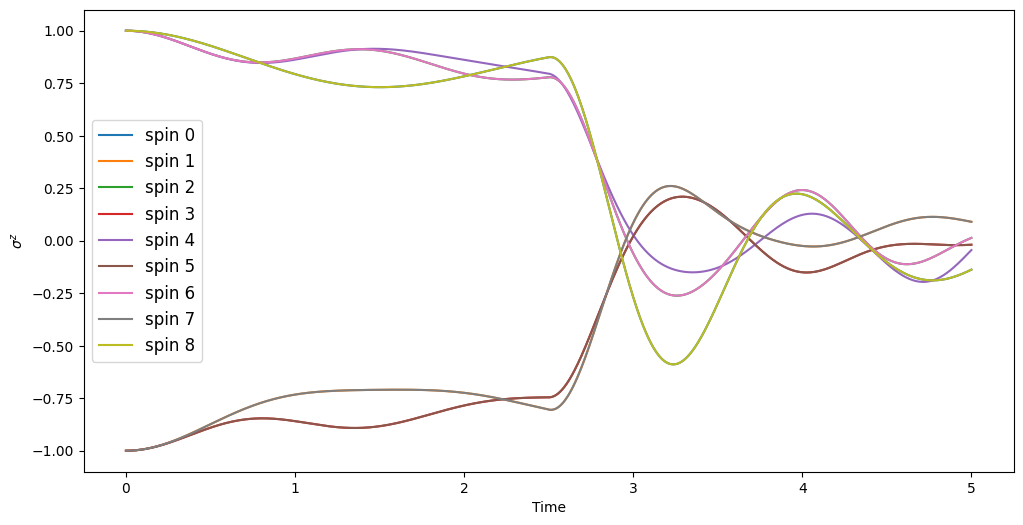

In [53]:
# Plot the results
get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]

exp_val = [get_result(i, evolution_result) for i in range(N)]

# Plot the results
fig = plt.figure(figsize=(12, 6))
for i in range(N):  
    plt.plot(steps, exp_val[i],label=f'spin {i}')
plt.legend(fontsize=12)
plt.ylabel("$\sigma^z $")
plt.xlabel("Time")



We can see that the prior to the addition of the magnetic field, the system stays relatively stationary. With the transverse field, the system quickly mixes. 

## Exercise 2 (Optional) 

a. Adjust the time dependent magnetic field to now be a sine function with amplitude 2.0, and frequency $2\pi$.

b. Consider now a disordered spin chain with varying couplings

c. Observe the behavior of the following observables: spin correlators $\langle \sigma^z_i \sigma^z_j \rangle$ and the magnetization $M = \frac{1}{N} \sum \langle\sigma^z_i\rangle$

In [ ]:
# Define a time dependent B field
delay=2.5
def B_field(time):
    if time<delay:
        B=0
    else:
        B=2.0
        # B=2.0*np.sin(2*np.pi*time)
    return B

observables=[spin.z(0)*spin.z(1)]